# 0f - Extract regional climate and glacier characteristics together with some median response timescale and lowess fit GMIP3 estimates
- creates `3_shift_summary_region_characteristics.csv` 
- uses some intermediate data to create this dataset with many variables (data documented in `README_data.md`)


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from oggm import utils
import oggm
from help_functions import get_glob_temp_exp
glob_temp = np.arange(-0.2,6.8,0.1)
add = ''
# add= '_temp_above_0_8'
approach = '_via_5yravg'
DATE = 'Feb12_2024'

In [2]:
pd_clim_past = pd.read_csv('../0_pre_post_processing/_intermediate_data/temp_prcp_past_gswp3-w5e5_glacier_regionally.csv', index_col=0)
pd_global_temp_past = pd_clim_past.loc[pd_clim_past.variable == 'temperature']
# get some RGI6 glacier statistics 
df_rgi6g = pd.read_hdf(utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5'))
df_rgi6g = df_rgi6g.loc[df_rgi6g.Connect != 2]

# there are -999 values that need to be set to NaN values!!!
print(len(df_rgi6g.loc[df_rgi6g['Zmax'] == -999,'Zmax']), len(df_rgi6g.loc[df_rgi6g['Zmin'] == -999,'Zmin']),
      len(df_rgi6g.loc[df_rgi6g['Zmed'] == -999,'Zmed']))
df_rgi6g.loc[df_rgi6g['Zmin'] == -999,'Zmin'] = np.NaN
df_rgi6g.loc[df_rgi6g['Zmax'] == -999,'Zmax'] = np.NaN
df_rgi6g.loc[df_rgi6g['Zmed'] == -999,'Zmed'] = np.NaN
# one glacier has a length of -9 .... 
df_rgi6g.loc[df_rgi6g['Lmax'] == -9,'Lmax'] = np.NaN

# check that there are no -999 values elsewhere (which are actuall NaN values)
assert df_rgi6g.Area.min() >0
# make sure that there are no Area NaN values !!!
assert np.all(~np.isnan(df_rgi6g.Area))
# make sure that there are no additional glaciers with negative lengths ... 
assert df_rgi6g.Lmax.min() >=0
assert np.all(df_rgi6g.Slope.min()!=-999)
assert np.all(df_rgi6g.CenLat.min() >=-90)
assert np.all(df_rgi6g.CenLat.max() <=90)


df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))
rgidf_dict = {}
rgidf_vol = {}
rgidf_vol_all = 0
slope_avg_d = {}
slope_avg_d_area_weighted = {}
lat_d_area_weighted={}
rgi_regs = list(df_rgi6g['O1Region'].unique())
elev_diff_d_area_weighted={}
marine_term_ratio_d_100largest_glac = {}
geodetic_obs_area_weighted_d={}
mean_vol_10_largest_glac = {}
ice_cap_ratio_d_100largest_glac = {}
elev_diff_to_med_d_area_weighted = {}
max_elev_d_area_weighted = {}
mean_area_10_largest_glac =  {}
mean_len_10_largest_glac =  {}
min_elev_d_area_weighted = {}

rgi_regs_global = ['All'] + rgi_regs

for rgi_reg in rgi_regs_global:
    if rgi_reg != 'All':
        rgidf = df_rgi6g.loc[df_rgi6g.O1Region == rgi_reg]
    else:
        rgidf = df_rgi6g

    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included, level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf.loc[rgidf.index,'vol_itmix_m3'] = df_itmix.loc[rgidf.index]['vol_itmix_m3']
    rgidf_dict[rgi_reg] = rgidf
    
    rgidf_vol[rgi_reg] = df_itmix.loc[rgidf.index]['vol_itmix_m3'].sum()
    rgidf_vol_all += df_itmix.loc[rgidf.index]['vol_itmix_m3'].sum()
    slope_avg = np.average(rgidf['Slope'], weights=df_itmix.loc[rgidf.index]['vol_itmix_m3'].values)
    slope_avg_d[rgi_reg] = slope_avg
    slope_avg_d_area_weighted[rgi_reg] = np.average(rgidf['Slope'], weights=rgidf.Area)
    lat_d_area_weighted[rgi_reg] = np.average(rgidf.CenLat, weights=rgidf.Area)
    if len(rgidf[['Area','Zmin', 'Zmed','Zmax']].dropna())>500: ### need at least 500 glaciers with data
        elev_diff_to_med_d_area_weighted[rgi_reg] = np.average(rgidf[['Area','Zmin', 'Zmed','Zmax']].dropna().Zmax - rgidf[['Area','Zmin', 'Zmed','Zmax']].dropna().Zmed,
                                                               weights=rgidf[['Area','Zmin', 'Zmed','Zmax']].dropna().Area)
    else:
        elev_diff_to_med_d_area_weighted[rgi_reg]  = np.NaN
    elev_diff_d_area_weighted[rgi_reg] = np.average(rgidf[['Area','Zmin', 'Zmax']].dropna().Zmax - rgidf[['Area','Zmin', 'Zmax']].dropna().Zmin,
                                                    weights=rgidf[['Area','Zmin', 'Zmax']].dropna().Area)
    # new stuff
    max_elev_d_area_weighted[rgi_reg] = np.average(rgidf[['Area', 'Zmax']].dropna().Zmax, weights=rgidf[['Area','Zmax']].dropna().Area)  # Regine's idea 
    min_elev_d_area_weighted[rgi_reg] = np.average(rgidf[['Area', 'Zmin']].dropna().Zmin, weights=rgidf[['Area','Zmin']].dropna().Area)  

    # ratio of tidewater glaciers in 100 by volume largest glaciers of region 
    counti = rgidf.sort_values(by='vol_itmix_m3')[-100:].groupby('IsTidewater').count()['TermType']
    if True not in counti.index:
        marine_term_ratio_d_100largest_glac[rgi_reg] = 0
    else:
        marine_term_ratio_d_100largest_glac[rgi_reg] = counti[True]/100
    
    mean_vol_10_largest_glac[rgi_reg] = df_itmix.loc[rgidf.index]['vol_itmix_m3'].sort_values().iloc[-10:].mean()/1e9 #km3
    mean_area_10_largest_glac[rgi_reg] = rgidf.Area.sort_values().iloc[-10:].mean() #km2
    mean_len_10_largest_glac[rgi_reg] = rgidf.Lmax.sort_values().iloc[-10:].mean()/1e3 #km

    #geodetic MB data
    geod = utils.get_geodetic_mb_dataframe().loc[utils.get_geodetic_mb_dataframe().period=='2000-01-01_2020-01-01']
    geod_avg = np.average(geod.loc[rgidf.index]['dmdtda'], weights = geod.loc[rgidf.index]['area'])
    geodetic_obs_area_weighted_d[rgi_reg] = geod_avg
    
    # ice cap count of 100 by volume largest glaciers
    counti_ice_cap = rgidf.sort_values(by='vol_itmix_m3')[-100:].groupby('GlacierType').count()['Name']
    if 'Ice cap' not in counti_ice_cap:
        ice_cap_ratio_d_100largest_glac[rgi_reg] = 0
    else:
        ice_cap_ratio_d_100largest_glac[rgi_reg] = counti_ice_cap['Ice cap']/100
pd_rel_vol = (100*pd.DataFrame(index=['vol_relperc_itmix'],data=rgidf_vol)/rgidf_vol_all).T
np.testing.assert_allclose(pd_rel_vol.sum(), 100)

17 11 2779


In [3]:
df = pd.DataFrame(index=rgi_regs_global)
df['rgi_reg'] = rgi_regs_global
df['region'] = rgi_regs_global
df.loc[df.rgi_reg=='All', 'region'] = 'Globally'

In [4]:
for period in ['2000-2019_vs_1901-1920']: # , '1986-2005_vs_1901-1920', '1995-2014_vs_1901-1920']:  <--  <- at the end we decided to use 2000 to 2019  vs 1901-1920...
    pd_global_temp_past_per =pd_global_temp_past.loc[pd_global_temp_past.period == period]
    pd_global_temp_past_per.index = pd_global_temp_past_per.rgi_reg
    df[f'temp_ch_avg_{period}'] = pd_global_temp_past_per.loc[df.rgi_reg,'average_change'].values

for period in ['2000-2019']: #,'1981-2000','1995-2014']: <- at the end we decided to use 2000 to 2019 
    # average temperature 
    pd_global_temp_past_per = pd_clim_past.loc[(pd_clim_past.variable=='temperature') & (pd_clim_past.period==period)]
    pd_global_temp_past_per.index = pd_global_temp_past_per.rgi_reg
    df[f'temp_avg_{period}'] = pd_global_temp_past_per.loc[df.rgi_reg,'average'].values

    # average precipitation 
    pd_global_prcp_past_per = pd_clim_past.loc[(pd_clim_past.variable=='precipitation') & (pd_clim_past.period==period)]
    pd_global_prcp_past_per.index = pd_global_prcp_past_per.rgi_reg
    df[f'prcp_avg_{period}'] = pd_global_prcp_past_per.loc[df.rgi_reg,'average'].values
    
    # average continentality index 
    pd_global_temp_ci_past_per = pd_clim_past.loc[(pd_clim_past.variable=='temperature_continentality_index') & (pd_clim_past.period==period)]
    pd_global_temp_ci_past_per.index = pd_global_temp_ci_past_per.rgi_reg
    df[f'continentality_index_avg_{period}'] = pd_global_temp_ci_past_per.loc[df.rgi_reg,'average'].values

for _reg in ['', '_ref_1986-2005']:
    if _reg =='_ref_1986-2005':
        add = -0.69
    else:
        add = 0
    for j, rgi_reg in enumerate(rgi_regs_global):
    
        region = f'RGI{rgi_reg}_glacier'
        if rgi_reg == 'All':
            region = 'global_glacier'
        glob_temp_ch = get_glob_temp_exp(region='global')['temp_ch_ipcc'].values + add
        glob_temp_reg = get_glob_temp_exp(region=region)['temp_ch_ipcc'].values + add
        slope, intercept, rval, pval, stderr = scipy.stats.linregress(glob_temp_ch, glob_temp_reg)
    
        df.loc[df.rgi_reg==rgi_reg,f'median_reg_vs_glob_ch{_reg}'] =  np.median(glob_temp_reg / glob_temp_ch).round(2)
        df.loc[df.rgi_reg==rgi_reg,f'median_reg_vs_glob_temp_ch_above_zero_eight_deg{_reg}'] =  np.median(glob_temp_reg[glob_temp_reg>=0.8] / glob_temp_ch[glob_temp_reg>=0.8]).round(2)
        df.loc[df.rgi_reg==rgi_reg,f'median_reg_vs_glob_temp_ch_1.5_3.0{_reg}'] =  np.median(glob_temp_reg[(glob_temp_reg>=1.5)&(glob_temp_reg<=3.0)] / glob_temp_ch[(glob_temp_reg>=1.5)&(glob_temp_reg<=3.0)]).round(2)
        df.loc[df.rgi_reg==rgi_reg,f'slope_fit_reg_vs_glob_ch{_reg}'] =  slope.round(1)
    
    
for region in rgi_regs_global:
    #df.loc[region,'slope_weighted_vol_avg'] = slope_avg_d[region] ##decided to do area weighted averages for consistency
    df.loc[region,'slope_weighted_area_avg'] = slope_avg_d_area_weighted[region]
    df.loc[region,'lat_absolute_weighted_area_avg'] = np.abs(lat_d_area_weighted[region])
    df.loc[region,'lat_weighted_area_avg'] = lat_d_area_weighted[region]
    df.loc[region,'marine_term_ratio_hundredlargest_glac'] = marine_term_ratio_d_100largest_glac[region]
    df.loc[region,'geodetic_obs_area_weighted'] =geodetic_obs_area_weighted_d[region]
    df.loc[region,'mean_vol_ten_largest_glac'] =mean_vol_10_largest_glac[region]
    df.loc[region,'elev_diff_area_weighted'] =elev_diff_d_area_weighted[region]
    
    # we don't have median elevation values for RGI19-> so we can not really use that characteristic ...
    # df.loc[region,'elev_diff_to_med_area_weighted'] = elev_diff_to_med_d_area_weighted[region]
    
    df.loc[region,'ice_cap_ratio_hundredlargest_glac'] = ice_cap_ratio_d_100largest_glac[region]
    df.loc[region,'max_elev_area_weighted'] = max_elev_d_area_weighted[region]
    df.loc[region,'min_elev_area_weighted'] = min_elev_d_area_weighted[region]
    df.loc[region,'mean_area_ten_largest_glac'] =mean_area_10_largest_glac[region]
    #df.loc[region,'mean_len_ten_largest_glac'] =mean_len_10_largest_glac[region] ##<-- not used anymore...


In [5]:
_resp_time = pd.read_csv('../data/resp_time_shifted_X%_threshold25%_for_deltaT_rgi_reg_roll_volume_21yravg.csv', index_col=[0])
d_temp = 0.2
for j,rgi_reg in enumerate(_resp_time.rgi_reg.unique()):
    for perc in [50, 80]:
        for temp in [1.5,3.0]: 
            _resp_time_r = _resp_time.loc[_resp_time.rgi_reg==rgi_reg]
            _resp_time_r_temp = _resp_time_r.loc[(_resp_time_r.temp_ch_ipcc>=temp-d_temp) & (_resp_time_r.temp_ch_ipcc<=temp+d_temp)]
            _resp_time_r_temp_sel = _resp_time_r_temp[[f'resp_time_-{perc}%']].quantile([0.05,0.25,0.5,0.75,0.95])
            if rgi_reg != 'All':
                _rgi_reg = rgi_reg[3:]
            else:
                _rgi_reg = 'All'
            if temp == 1.5:
                df.loc[_rgi_reg, f'resp_time_-{perc}%_1_5_deg'] = _resp_time_r_temp_sel.loc[0.5].values.squeeze()
            elif temp == 3.0:
                df.loc[_rgi_reg, f'resp_time_-{perc}%_3_0_deg'] = _resp_time_r_temp_sel.loc[0.5].values.squeeze()
                


In [6]:
### only global models ... resp time estimates ... 
_resp_time_global = _resp_time[(_resp_time.model_author =='PyGEM-OGGM_v13') | (_resp_time.model_author =='OGGM_v16')
               | (_resp_time.model_author =='GloGEMflow') | (_resp_time.model_author =='GLIMB')]
print(_resp_time_global.model_author.unique())
for j,rgi_reg in enumerate(_resp_time_global.rgi_reg.unique()):
    for perc in [50, 80]:
        for temp in [1.5,3.0]: 
            _resp_time_r = _resp_time_global.loc[_resp_time_global.rgi_reg==rgi_reg]
            _resp_time_r_temp = _resp_time_r.loc[(_resp_time_r.temp_ch_ipcc>=temp-d_temp) & (_resp_time_r.temp_ch_ipcc<=temp+d_temp)]
            _resp_time_r_temp_sel = _resp_time_r_temp[[f'resp_time_-{perc}%']].quantile([0.05,0.25,0.5,0.75,0.95])
            if rgi_reg != 'All':
                _rgi_reg = rgi_reg[3:]
            else:
                _rgi_reg = 'All'
            if temp == 1.5:
                df.loc[_rgi_reg, f'resp_time_-{perc}%_1_5_deg_only_global_models'] = _resp_time_r_temp_sel.loc[0.5].values.squeeze()
            elif temp == 3.0:
                df.loc[_rgi_reg, f'resp_time_-{perc}%_3_0_deg_only_global_models'] = _resp_time_r_temp_sel.loc[0.5].values.squeeze()
                


['GLIMB' 'GloGEMflow' 'OGGM_v16' 'PyGEM-OGGM_v13']


In [7]:
# let's also add the hugonnet_farinotti statistics .. 
pd_rgi_stats_w_hugonnet = pd.read_csv(f'../0_pre_post_processing/_intermediate_data/rgi_vs_2020_volume_hugonnet_estimates{DATE}.csv')

# new: let's remvoe a few columns from pd_rgi_stats_w_hugonnet that we only used for testing or to compute intermediate other data
pd_rgi_stats_w_hugonnet = pd_rgi_stats_w_hugonnet.drop(columns=['regional_dvol_dt_2000_2019_vs_2020_vol_via_20yravg', # estimates of volume change by using the 20-year data from Hugonnet (not used anymore because we use now the 5-year estimates)
                 'regional_dvol_dt_2000_2019_vs_2000_vol_via_20yravg',
                  'regional_volume_m3_2020_via_20yravg', # same for estimates of volume 
       'regional_volume_m3_2000_via_20yravg',
                 'dvoldt_m3_hugonnet_2015-01-01_2020-01-01', # this is the raw Hugonnet et al. 2021 data, but we don't need this anymore
               'dvoldt_m3_hugonnet_2010-01-01_2015-01-01',
               'dvoldt_m3_hugonnet_2005-01-01_2010-01-01',
               'dvoldt_m3_hugonnet_2000-01-01_2005-01-01',
                 'loss_m3_via_5yravg', 'gain_m3_via_5yravg',
                'yr_diff_rgi_vs_2020', # year difference from RGI year to 2020... just used for computations within postprocessing data
            'regional_dvol_dt_2000_2019_vs_2020_vol_via_5yravg', # not interested in the vs 2020 estimate, 
            'regional_dvol_dt_2000_2019_vs_2000_vol_via_5yravg', # not interested in the vs 2020 estimate, 
                 'regional_volume_m3_itmix_vs_2000'
                ])

rgi_reg_l = pd_rgi_stats_w_hugonnet.region.values
rgi_reg_l[rgi_reg_l=='Globally'] = 'All'
#rgi_reg_l.replace('Globally':'All')
for c in pd_rgi_stats_w_hugonnet.columns.drop('region'):
    df.loc[rgi_reg_l, c] = pd_rgi_stats_w_hugonnet[c].values
df['20yr_regional_dvol_dt_2000_2019_vs_2000_vol_%'] = np.abs(20*100*df['dvoldt_m3_hugonnet']/df[f'regional_volume_m3_2000{approach}'])

### let's drop these aswell as these are not anymore actively used... 
###`median_reg_vs_glob_temp_ch_above_zero_eight_deg`: same as `median_reg_vs_glob_ch` but only with experiments above 0.8°C - no unit
###`median_reg_vs_glob_temp_ch_above_zero_eight_deg_ref_1986-2005`: same as `median_reg_vs_glob_ch_ref_1986-2005` but only with experiments above 0.8°C - no unit
df = df.drop(columns=['median_reg_vs_glob_temp_ch_above_zero_eight_deg','median_reg_vs_glob_temp_ch_above_zero_eight_deg_ref_1986-2005'])

In [8]:
### add two lowess fit characteristics that are necessary for Fig. 4... 
pd_sel = pd.read_csv(f'../data/lowess_fit_rel_2020_101yr_avg_steady_state_{DATE}.csv', index_col=[0])
pd_sel['rgi_reg'] = pd_sel.region.values

pd_sel.index = pd_sel.temp_ch.round(2)
pd_sel['ice_loss_rel_2020'] = 100-pd_sel['0.5']
pd_sel['x']= pd_sel.index

for reg in df.index:
    pd_reg = pd_sel.loc[pd_sel.region==reg]
    pd_reg_1_2 = pd_reg.loc[np.abs(pd_reg.x-1.2).idxmin()]
    ice_loss_reg_1_2 = pd_reg_1_2[f'ice_loss_rel_2020']
    df.loc[reg,'ice_loss_1.2°C_%_rel_2020'] =  ice_loss_reg_1_2

    pd_reg_1_5 = pd_reg.loc[np.abs(pd_reg.x-1.5).idxmin()]
    ice_loss_reg_1_5 = pd_reg_1_5[f'ice_loss_rel_2020']

    pd_reg_3 = pd_reg.loc[np.abs(pd_reg.x-3).idxmin()]
    ice_loss_reg_3 = pd_reg_3[f'ice_loss_rel_2020']
    
    ice_loss_diff = ice_loss_reg_3 - ice_loss_reg_1_5
    tenth_deg_celsius_ch=15
    df.loc[reg, 'ice_loss_slope_1.5_to_3.0_per_tenth_degC_rel_2020'] = (ice_loss_diff)/tenth_deg_celsius_ch


In [9]:
# todo - low priority: remove regional_volume_m3_2020_via_5yravg, and instead only show numbers in gt mass...
#df['gt_2020_via_5yravg'] = df['regional_volume_m3_2020_via_5yravg']*900/ (1e9*1e3)
#df = df.drop(columns='regional_volume_m3_2020_via_5yravg')

In [10]:
df.columns

Index(['rgi_reg', 'region', 'temp_ch_avg_2000-2019_vs_1901-1920',
       'temp_avg_2000-2019', 'prcp_avg_2000-2019',
       'continentality_index_avg_2000-2019', 'median_reg_vs_glob_ch',
       'median_reg_vs_glob_temp_ch_1.5_3.0', 'slope_fit_reg_vs_glob_ch',
       'median_reg_vs_glob_ch_ref_1986-2005',
       'median_reg_vs_glob_temp_ch_1.5_3.0_ref_1986-2005',
       'slope_fit_reg_vs_glob_ch_ref_1986-2005', 'slope_weighted_area_avg',
       'lat_absolute_weighted_area_avg', 'lat_weighted_area_avg',
       'marine_term_ratio_hundredlargest_glac', 'geodetic_obs_area_weighted',
       'mean_vol_ten_largest_glac', 'elev_diff_area_weighted',
       'ice_cap_ratio_hundredlargest_glac', 'max_elev_area_weighted',
       'min_elev_area_weighted', 'mean_area_ten_largest_glac',
       'resp_time_-50%_1_5_deg', 'resp_time_-50%_3_0_deg',
       'resp_time_-80%_1_5_deg', 'resp_time_-80%_3_0_deg',
       'resp_time_-50%_1_5_deg_only_global_models',
       'resp_time_-50%_3_0_deg_only_global_models

In [11]:
df.to_csv(f'../data/3_shift_summary_region_characteristics{DATE}.csv') 

### Some small checks... 

1_5      slope_weighted_area_avg  resp_time_-80%_1_5_deg_only_global_models  \
All                11.407291                                      463.0   
01                 13.940351                                      104.0   
02                 18.326460                                       57.5   
03                  9.618978                                      644.5   
04                 11.503623                                      241.5   
05                 10.303661                                      373.0   
06                  6.743030                                      316.0   
07                  8.754521                                      318.5   
08                 11.861046                                      150.5   
09                 11.856636                                      445.0   
10                 18.374719                                       44.0   
11                 20.931762                                       35.5   
12                 24

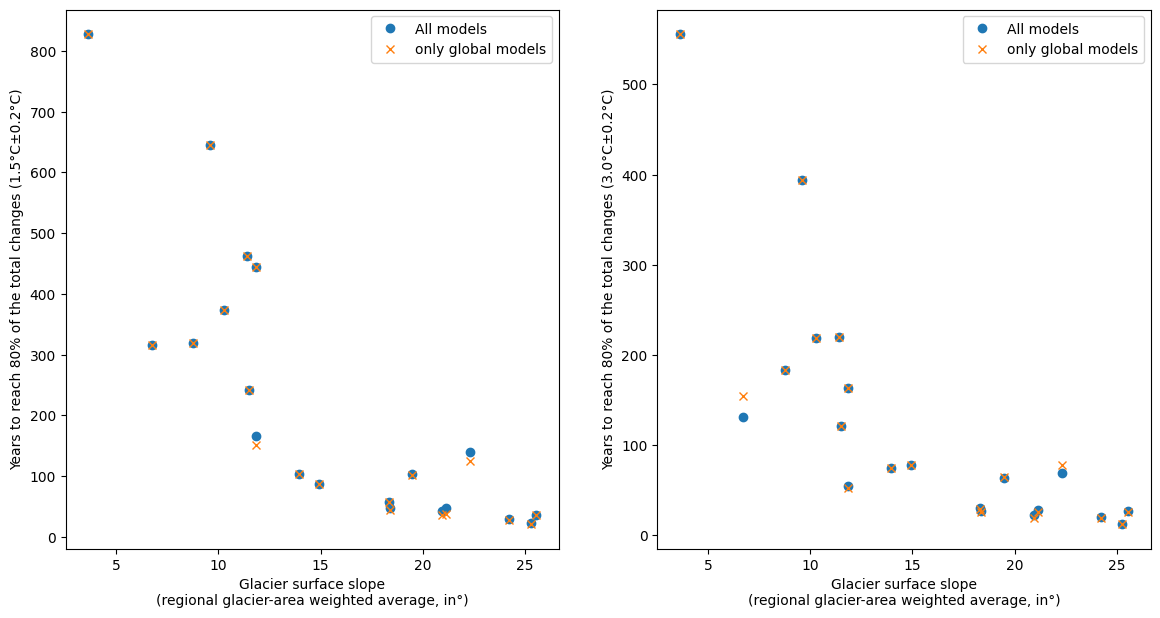

In [12]:
plt.figure(figsize=(14,7))
for j, temp in zip([1,2],['1_5','3_0']):
    plt.subplot(1,2,j)
    plt.plot(df.slope_weighted_area_avg,
             df[f'resp_time_-{perc}%_{temp}_deg'], 'o', label='All models')
    plt.plot(df.slope_weighted_area_avg,
             df[f'resp_time_-{perc}%_{temp}_deg_only_global_models'], 'x', label='only global models')
    plt.legend()
    if temp == '1_5':
        plt.ylabel(f'Years to reach {perc}% of the total changes (1.5°C±0.2°C)')
    else:
        plt.ylabel(f'Years to reach {perc}% of the total changes (3.0°C±0.2°C)')
    plt.xlabel('Glacier surface slope\n(regional glacier-area weighted average, in°)')
    print(temp, df[['slope_weighted_area_avg',
                   f'resp_time_-{perc}%_{temp}_deg_only_global_models',
                   f'resp_time_-{perc}%_{temp}_deg']])


1_5      slope_weighted_area_avg  resp_time_-80%_1_5_deg_only_global_models  \
All                11.407291                                      463.0   
01                 13.940351                                      104.0   
02                 18.326460                                       57.5   
03                  9.618978                                      644.5   
04                 11.503623                                      241.5   
05                 10.303661                                      373.0   
06                  6.743030                                      316.0   
07                  8.754521                                      318.5   
08                 11.861046                                      150.5   
09                 11.856636                                      445.0   
10                 18.374719                                       44.0   
11                 20.931762                                       35.5   
12                 24

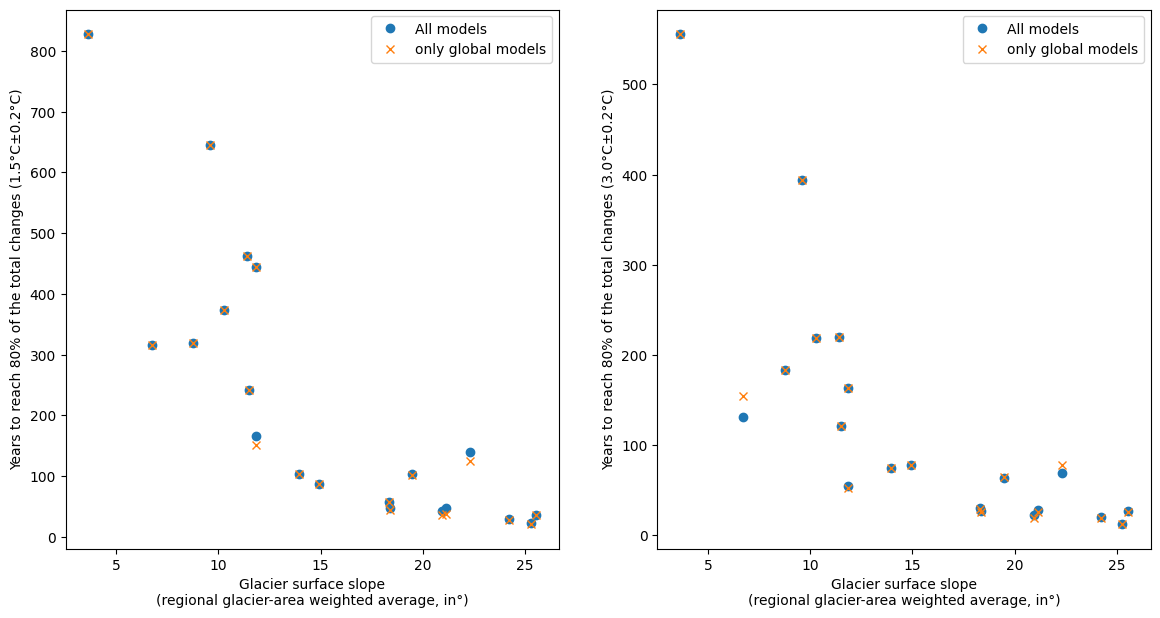

In [13]:
plt.figure(figsize=(14,7))
for j, temp in zip([1,2],['1_5','3_0']):
    plt.subplot(1,2,j)
    plt.plot(df.slope_weighted_area_avg,
             df[f'resp_time_-{perc}%_{temp}_deg'], 'o', label='All models')
    plt.plot(df.slope_weighted_area_avg,
             df[f'resp_time_-{perc}%_{temp}_deg_only_global_models'], 'x', label='only global models')
    plt.legend()
    if temp == '1_5':
        plt.ylabel(f'Years to reach {perc}% of the total changes (1.5°C±0.2°C)')
    else:
        plt.ylabel(f'Years to reach {perc}% of the total changes (3.0°C±0.2°C)')
    plt.xlabel('Glacier surface slope\n(regional glacier-area weighted average, in°)')
    print(temp, df[['slope_weighted_area_avg',
                   f'resp_time_-{perc}%_{temp}_deg_only_global_models',
                   f'resp_time_-{perc}%_{temp}_deg']])


1_5 All    1.000000
01     1.000000
02     1.000000
03     1.000000
04     1.000000
05     1.000000
06     1.000000
07     1.000000
08     0.903904
09     1.000000
10     0.926316
11     0.835294
12     0.933333
13     0.990291
14     0.888889
15     0.778947
16     0.913043
17     1.000000
18     1.000000
19     1.000000
dtype: float64
3_0 All    1.000000
01     1.000000
02     0.950000
03     1.000000
04     1.000000
05     1.000000
06     1.175573
07     1.000000
08     0.962963
09     1.000000
10     0.980769
11     0.822222
12     0.950000
13     1.023810
14     1.130435
15     0.910714
16     1.000000
17     1.000000
18     0.980769
19     1.000000
dtype: float64


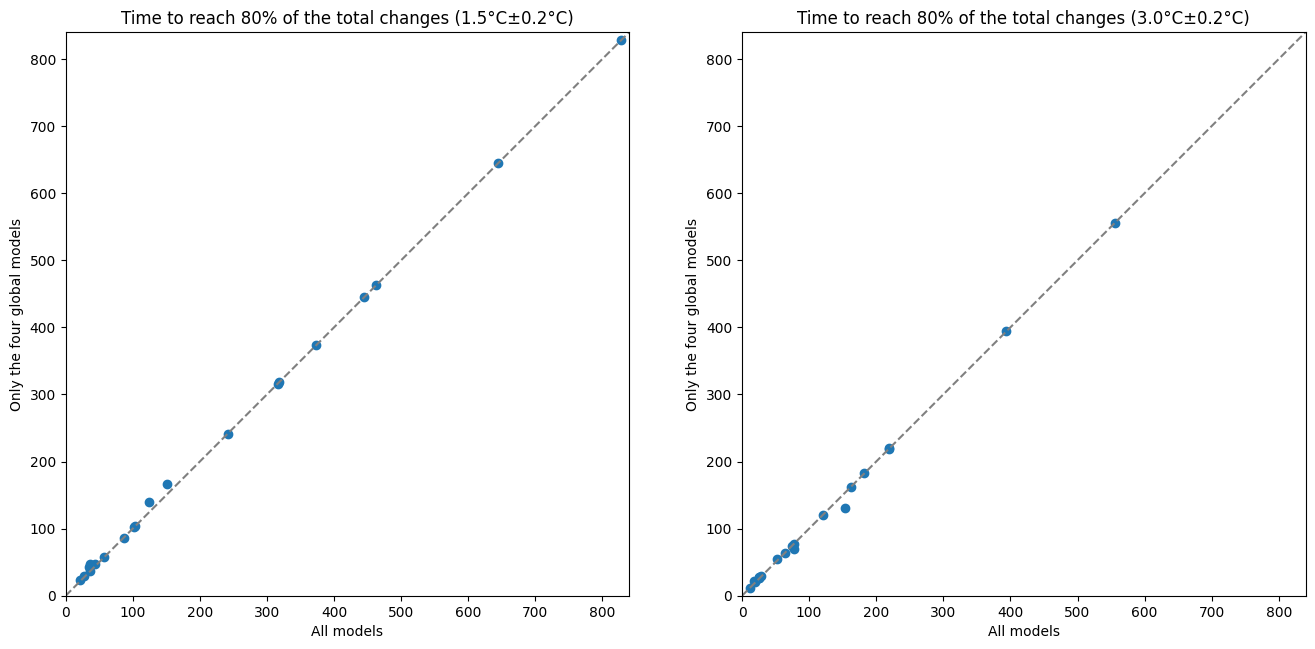

In [14]:
perc = '80'
plt.figure(figsize=(16,8))
for j, temp in zip([1,2],['1_5','3_0']):
    plt.subplot(1,2,j)

    plt.plot(df[f'resp_time_-{perc}%_{temp}_deg_only_global_models'],
             df[f'resp_time_-{perc}%_{temp}_deg'], 'o')
    plt.xlabel('All models')
    plt.ylabel('Only the four global models')
    if temp == '1_5':
        plt.title(f'Time to reach {perc}% of the total changes (1.5°C±0.2°C)')
    else:
        plt.title(f'Time to reach {perc}% of the total changes (3.0°C±0.2°C)')

    plt.gca().set_aspect('equal')

    plt.plot([0,850],[0,850],ls='--', color='grey')
    plt.ylim([0,840])
    plt.xlim([0,840])
    print(temp, df[f'resp_time_-{perc}%_{temp}_deg_only_global_models']/df[f'resp_time_-{perc}%_{temp}_deg'])
plt.savefig('../0_pre_post_processing/figures/3b_resp_time_only_global_vs_all_comparison.png')